# t-SNE tutorial

In [5]:
from contextlib import ExitStack
import numpy as np
from sklearn.manifold import TSNE
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import os
import codecs

In [6]:
filesdir = "20news-bydate-train/"   # path to 20news-bydate-train/ remember to put '/' at the end
labels = [fname for fname in os.listdir(filesdir) if not fname.startswith('.')]
dirs = [filesdir + label for label in labels][:3]
files = [os.listdir(directory) for directory in dirs][:3]
lengths = [len(f) for f in files]
lengths
multiplied_labels = [[label]*length for label,length in zip(labels,lengths)]
flat_labels = [x for sublist in multiplied_labels for x in sublist]
flat_files = [x for sublist in files for x in sublist]
flat_files = [filesdir + flat_label + '/' + flat_file for flat_label,flat_file in zip(flat_labels,flat_files)]

filenames = flat_files

stemmer = SnowballStemmer('english')
analyzer = TfidfVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


with ExitStack() as stack:
    
    files = []
    for fname in filenames:
        with codecs.open(fname, 'r', encoding='utf-8',
                 errors='ignore') as f:
            files.append(stack.enter_context(f).read())
            f.close()
    vectorizer = TfidfVectorizer(stop_words='english', analyzer=stemmed_words)
    Y = vectorizer.fit_transform(files).todense()

In [13]:
# X_embedded = TSNE(n_components=2).fit_transform(Y)

# print(X_embedded)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
components = pca.fit_transform(Y)

[[  1.8878844 -14.069935 ]
 [-14.323795  -16.280018 ]
 [ 14.592631   42.113995 ]
 ...
 [-24.708797   42.44195  ]
 [-53.17609    -0.5104627]
 [-18.496855   12.377358 ]]


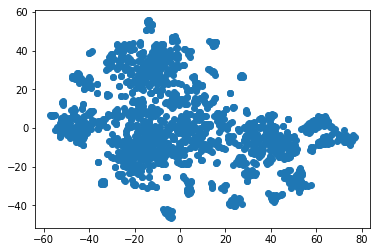

In [9]:
X_embedded = TSNE(n_components=2).fit_transform(components)

print(X_embedded)
    
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

In [11]:
def calculateSquare(str):
    if str == 'comp.graphics':
        return 0
    elif str == 'alt.atheism':
        return 1
    else:
        return 2

flat_list = [item for sublist in multiplied_labels for item in sublist]
label = list(map(calculateSquare, flat_list))

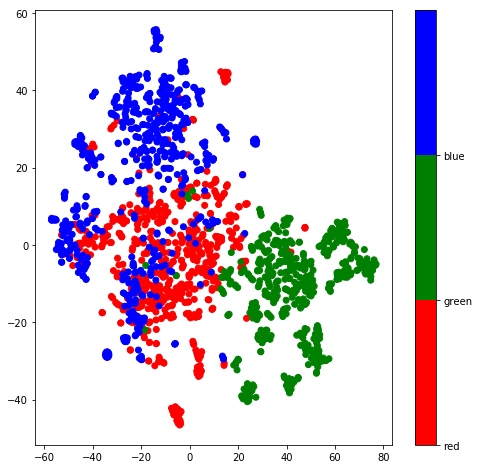

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = X_embedded[:,0]
y = X_embedded[:,1]
#label = list(map(calculateSquare, multiplied_labels))

colors = ['red','green','blue']

fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)